In [72]:
pip install pandas matplotlib seaborn pillow numpy scipy scikit-learn keras tensorflow opencv-python scikit-image pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import numpy as np

Number of images per class:
label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64
Mean image size: [260.38103175 196.57357143]
Standard deviation of image sizes: [39.91769674 35.2800022 ]


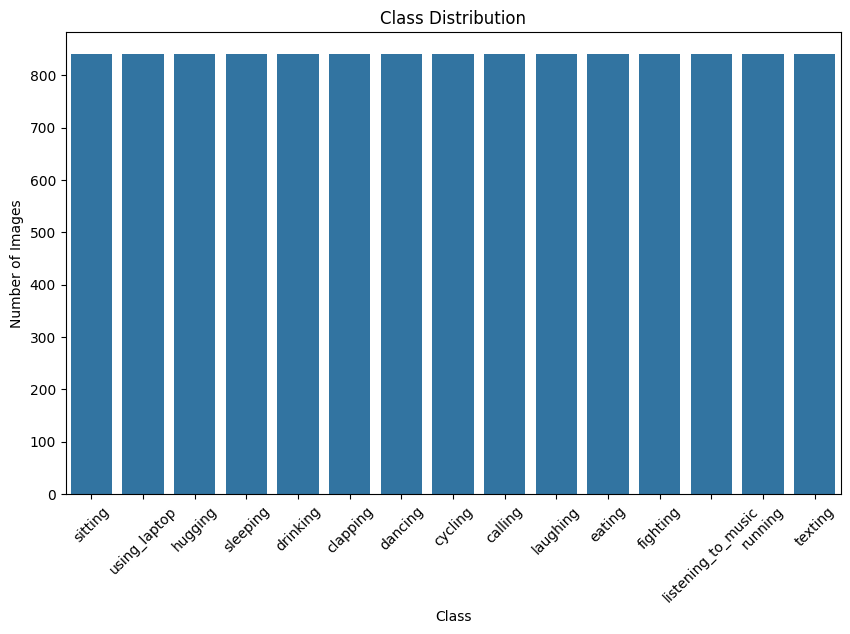

C:\Users\adity\AppData\Local\Temp\ipykernel_23864\2545280858.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_images_per_class = labels_df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)


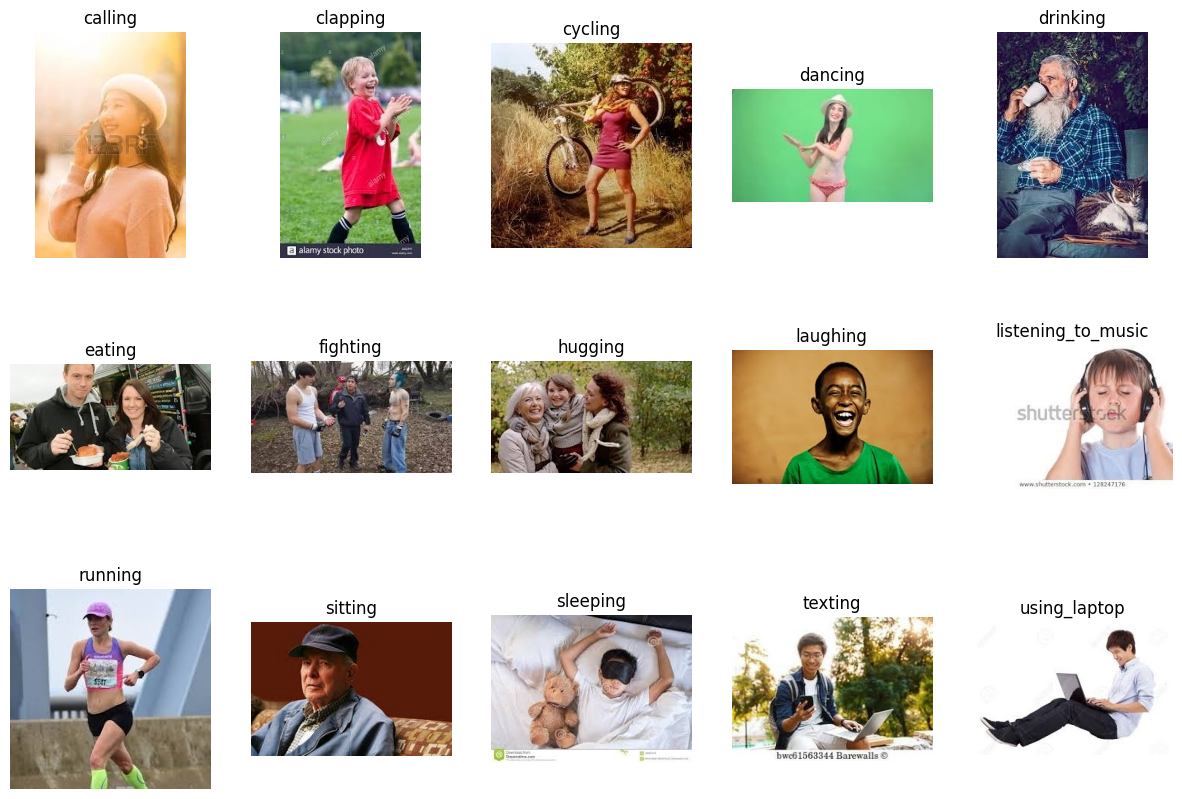

Classes with fewer images than average:
Series([], Name: count, dtype: int64)
Proposed strategies to address class imbalances:
1. Data Augmentation: Apply transformations such as rotation, flipping, and scaling to increase the number of images in underrepresented classes.
2. Resampling: Oversample the underrepresented classes or undersample the overrepresented classes to balance the dataset.


In [74]:
# Load the label.csv file
labels_df = pd.read_csv('label.csv')

# Overview of the dataset
# Count the number of images per class
class_counts = labels_df['label'].value_counts()

# Analyze the distribution of image sizes
image_sizes = []
image_folder = 'data'
for img_name in labels_df['filename']:
    img_path = os.path.join(image_folder, img_name)
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

image_sizes = np.array(image_sizes)
mean_size = np.mean(image_sizes, axis=0)
std_size = np.std(image_sizes, axis=0)

# Print observations
print(f"Number of images per class:\n{class_counts}")
print(f"Mean image size: {mean_size}")
print(f"Standard deviation of image sizes: {std_size}")

# Visualizations
# Bar plot for class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Display sample images from each class
sample_images_per_class = labels_df.groupby('label').apply(lambda x: x.sample(1)).reset_index(drop=True)
plt.figure(figsize=(15, 10))
for i, row in sample_images_per_class.iterrows():
    img_path = os.path.join(image_folder, row['filename'])
    with Image.open(img_path) as img:
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(row['label'])
        plt.axis('off')
plt.show()

# Class distribution analysis
# Check for class imbalances
class_imbalance = class_counts[class_counts < class_counts.mean()]

# Print observations
print(f"Classes with fewer images than average:\n{class_imbalance}")

# Propose strategies to address class imbalances
print("Proposed strategies to address class imbalances:")
print("1. Data Augmentation: Apply transformations such as rotation, flipping, and scaling to increase the number of images in underrepresented classes.")
print("2. Resampling: Oversample the underrepresented classes or undersample the overrepresented classes to balance the dataset.")

# 1.
## a)
- all classes have same number of images
- Mean image size: [260.38103175 196.57357143]
- Standard deviation of image sizes: [39.91769674 35.2800022 
## b)
- did that above
- some images have watermarks, that may result in wrong interpretations
## c)
- There are no class imbalances
- 

In [75]:
import cv2
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
import random

In [76]:
# trying data augmentation
def augment_image(img):
    # Rotation
    angle = random.randint(-15, 15)
    M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # Flipping
    flip = random.choice([-1, 0, 1])  # -1 = both axes, 0 = vertical, 1 = horizontal
    flipped = cv2.flip(rotated, flip)

    # Translation
    x_shift = random.randint(-10, 10)
    y_shift = random.randint(-10, 10)
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    translated = cv2.warpAffine(flipped, M, (flipped.shape[1], flipped.shape[0]))

    # Brightness and contrast adjustment
    brightness = random.randint(-30, 30)
    contrast = random.uniform(0.8, 1.2)
    augmented = cv2.convertScaleAbs(translated, alpha=contrast, beta=brightness)
    
    return augmented

In [77]:
# Load the CSV containing the labels
labels_df = pd.read_csv('label.csv')

# Function to extract HOG and Color Histogram features
def extract_features(image_path,augment = False):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (128, 128))
    
    # HOG features
    hog_features, _ = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    
    # Color histogram
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([img_resized], [i], None, [32], [0, 256])
        hist_features.extend(hist.flatten())
    
    # LBP features
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), range=(0, 59))

    # GLCM (Texture) Features
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_features = [contrast, dissimilarity, homogeneity, energy, correlation]

    # Color Moments (Mean, Variance, Skewness for each channel)
    color_moments = []
    for i in range(3):
        channel = img_resized[:, :, i]
        mean = np.mean(channel)
        variance = np.var(channel)
        skewness = skew(channel.ravel())
        color_moments.extend([mean, variance, skewness])

    # Concatenate all features into a single feature vector
    return np.hstack((hog_features, hist_features, lbp_hist, glcm_features, color_moments))


# Apply data augmentation to a portion of your dataset
augmented_features = []
augmented_labels = []
for index, row in labels_df.iterrows():
    image_path = f"data/{row['filename']}"
    
    # Original image
    original_feature = extract_features(image_path)
    augmented_features.append(original_feature)
    augmented_labels.append(row['label'])
    
    # Augmented image
    augmented_feature = extract_features(image_path, augment=True)
    augmented_features.append(augmented_feature)
    augmented_labels.append(row['label'])




KeyboardInterrupt: 

In [66]:
# Convert lists to numpy arrays
X = np.array(augmented_features)
y = LabelEncoder().fit_transform(augmented_labels)

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

# Initialize models
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest_150': RandomForestClassifier(n_estimators=150),
    'Random Forest_250': RandomForestClassifier(n_estimators=250),
    'Random Forest_350': RandomForestClassifier(n_estimators=350),
    'Random Forest_450': RandomForestClassifier(n_estimators=450),
    'Random Forest_550': RandomForestClassifier(n_estimators=550),
    'Perceptron': Perceptron(max_iter=10000, tol=1e-4)
}

# Train and evaluate each model, and save them using pickle
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print the accuracy of each model
    print(f'{model_name} Accuracy: {accuracy:.4f}')
    
    # Save the model using pickle
    with open(f'{model_name}_model.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)

# Using an ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()), 
    ('dt', DecisionTreeClassifier()), 
    ('nb', GaussianNB())
], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

# Calculate accuracy
ensemble_accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the ensemble model
print(f'Ensemble Model Accuracy: {ensemble_accuracy:.4f}')

# Save the ensemble model using pickle
with open('Ensemble_Model.pkl', 'wb') as ensemble_file:
    pickle.dump(ensemble_model, ensemble_file)


Naive Bayes Accuracy: 0.2198
Decision Tree Accuracy: 0.8214
Random Forest_150 Accuracy: 0.8488
Random Forest_250 Accuracy: 0.8516
Random Forest_350 Accuracy: 0.8571
Random Forest_450 Accuracy: 0.8587
Random Forest_550 Accuracy: 0.8552
Perceptron Accuracy: 0.1613
Ensemble Model Accuracy: 0.8373


# Pickle
- importing models from pickle files and running them again